# Analyzing Cities: A Case Study of Singapore with comparisons between Singapore and New York   
### Final Project: Data Science Professional Certificate by IBM
__Michael W.D. Kurz__

## Table of Contents <a name="ToC"></a>    
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>     
Return to [Table of Contents](#ToC)

As cities’ around the world grow larger it becomes increasingly important to understand their internal structure as well as the similarities and differences between cities. The analysis is intended as a case study focusing on two major cities: Singapore and New York City.   
    
First, focusing on Singapore I am using unsupervised machine learning techniques to identify clusters of similar neighborhoods within and across the five regions of Singapore (Central, North, North-East, East, and West). For this analysis I am defining similarity in terms of the types and number of amenities in the neighborhood. Thus, I describe each neighborhood as a vector of the amenities within the neighborhood. I augment this by demographic data on the residents of each neighborhood to gain a better understanding of which demographic groups reside most commonly in which kind of neighborhood. I will investigate whether similarity in terms of amenities correlates with similarity in terms of the demographic characteristics of residents.    
    
Identifying neighborhoods that are similar to each other in terms of amenities and terms demographic groups helps urban planners/city planners to make more informed decisions regarding zoning and the branding of areas of a city towards tourists and businesses. It may also help the proprietors of restaurants, bars, etc. to make informed decisions about the location of new venues. Additionally, the results can help residents that need to relocate from one part of the city to another to find neighborhoods with similar amenities.    
    
Next, I create a similar dataset of amenities within neighborhoods in New York City and identify similar neighborhoods within and across boroughs of New York City. This part of the analysis mirrors the analysis of Singapore but excludes demographic data. New York City and Singapore are both highly urbanized, densely populated areas with vastly diverse populations and both cities are regarded as financial and economic hubs. While comparisons such as the one in this analysis have been done in academic literature within countries, not much work has been done regarding comparisons cities across countries.     
    
Based on the neighborhood amenities data in New York and Singapore I will examine similarities across the two cities. This sort of across city comparisons can help, for example, expatriates or business travelers who move move to or travel to one of the cities identify neighborhoods that are similar to the one they currently live in. Since Singapore is located in South-East Asia and New York City in the USA, expatriates or business travelers who never have been to their destination city may find such analysis useful.

## Data <a name="data"></a>    
Return to [Table of Contents](#ToC)

___Neighborhood data New York City:___  
* Dataset
    
___Neighborhood data and demographic data Singapore:___
* neighborhoods
* demographic data
     
___Amenities data:___
* Foursquare API

### Data Collection and preparation

#### Neighborhoods in Singapore

In [1]:
import pandas as pd # use dataframes in Pyhton, read .csv-files etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np

import geopandas as gpd # use shapefiles
from pyproj import Proj, transform # change map projection
import folium # Libarary that contains a detailed world map and the ability to zoom in down to the city level
from geopy.geocoders import Nominatim # reverse geocoder API to get coordinates for addresses/cites, etc.

import json # read JSON files
import requests # call URLs

import matplotlib.pyplot as plt # data visualization
import matplotlib.cm as cm
import matplotlib.colors as colors

I use a shapefile of Singapore that contains the boundaries of a sub-zones. The shapefile is available under an open data license [from a website of the government of Singapore](https://geo.data.gov.sg/mp14-subzone-web-pl/2014/12/05/shp/mp14-subzone-web-pl.zip).     
The government of Singapore defines sub-zones as follows: _'Subzones are divisions within a planning area which are usually centred around a focal point such as neighbourhood centre or activity node.'_    

I use the file 'Master Plan 2014 Subzone Boundary (Web)'. The master plan is a medium term development plan for a period of 10-15 years.

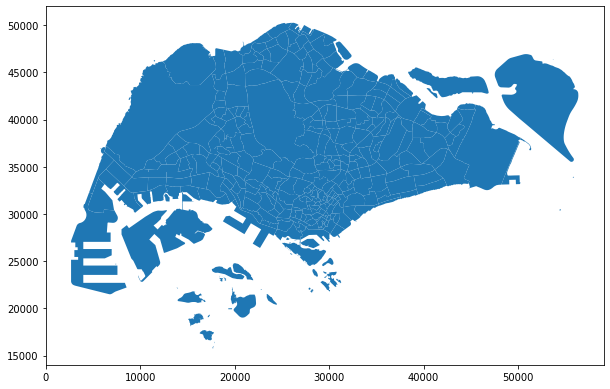

In [106]:
pathSing_shape = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\master-plan-2014-subzone-boundary-web-shp\MP14_SUBZONE_WEB_PL.shp'
singaporeShape = gpd.read_file(pathSing_shape)
ax = singaporeShape.plot(figsize=(10,7))
plt.show()

Coordinates in the shapefile are not longitude and latitude. Since I will be needing longitude and latitude coordiantes later on to get data from Foursquare, I will have to change to transform the coordinates. To do so, I need to get the projection of the map defined by the shapefile first:

In [107]:
singaporeShape.crs

{'proj': 'tmerc',
 'lat_0': 1.366666666666667,
 'lon_0': 103.8333333333333,
 'k': 1,
 'x_0': 28001.642,
 'y_0': 38744.572,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

The information in crs tells use how the map of Singapore is projected. In this case a transverse mercator projection (tmerc) centered on 1.367°E 103.83°N (lat_0, lon_0). x_0,y_0 are the corresponding x,y coordinates of the center point of the map. Units in the map are meters. I can now extract the x,y coordinates of the geometric center point of each neighborhood polygon (its centroid) from the shapefile and use the information about way the map in the shapefiel is projected to convert the the x,y coordinates of each point to longitude and latitude coordinates.

In [108]:
singaporeDf = pd.DataFrame(columns=['SubZone_Code', 'SubZone_Name','Region_Code', 'Region_Name', 'SubZoneArea', 'latitude', 'longitude', 'x', 'y']) 

projection_string = "+proj=tmerc +lat_0=1.366666666666667 +lon_0=103.8333333333333 +k=1 +x_0=28001.642 +y_0=38744.572 +datum=WGS84 +units=m +no_defs"
p = Proj(projection_string)

for index,row in singaporeShape.iterrows():
    lng, lat = p(row.geometry.centroid.x,row.geometry.centroid.y, inverse=True)
    singaporeDf.loc[index] = [row.SUBZONE_C, row.SUBZONE_N.lower(), row.REGION_C, row.REGION_N, row.geometry.area/10**6, lat, lng, row.geometry.centroid.x,row.geometry.centroid.y]

singaporeDf.head()

,SubZone_Code,SubZone_Name,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,MSSZ01,marina south,CR,CENTRAL REGION,1.630379,1.280531,103.865629,31595.835746,29220.187377
1,OTSZ01,pearl's hill,CR,CENTRAL REGION,0.559816,1.285613,103.839420,28679.063482,29782.051966
2,SRSZ03,boat quay,CR,CENTRAL REGION,0.160807,1.287355,103.848189,29654.959448,29974.655356
3,BMSZ08,henderson hill,CR,CENTRAL REGION,0.595429,1.286985,103.822382,26782.826115,29933.765194
4,BMSZ03,redhill,CR,CENTRAL REGION,0.387429,1.287635,103.817162,26201.958019,30005.703511


The above dataframe now contains for each neighborhood (subzone): the region it belongs to, its area in sq-km, latitude and longitude coordinates, and x,y coordinates. I will use the latitude and longitude coordinates primarily to obtain the venues data from Foursquare. The area in sq-km can be used to inform the choice of a reasonable radius for the search query in Foursquare as the neighborhoods seem to vary in size.

In [109]:
singaporeDf.loc[:,'SubZone_Code':'SubZoneArea'].groupby('Region_Name').describe()

SubZoneArea                                          \
                        count      mean       std       min       25%   
Region_Name                                                             
CENTRAL REGION          134.0  1.017952  1.078615  0.039438  0.337352   
EAST REGION              30.0  3.765656  6.179367  0.494504  1.529476   
NORTH REGION             41.0  3.400137  6.138037  0.143138  1.281297   
NORTH-EAST REGION        48.0  2.834449  9.526342  0.316882  0.947999   
WEST REGION              70.0  3.673004  9.612790  0.380202  0.914210   

                                                  
                        50%       75%        max  
Region_Name                                       
CENTRAL REGION     0.593604  1.347130   7.601894  
EAST REGION        2.383305  3.407323  35.096029  
NORTH REGION       1.648630  2.553464  37.147854  
NORTH-EAST REGION  1.331205  1.757305  67.250563  
WEST REGION        1.504424  2.463417  69.748299

Most neighborhoods are located in the central region (134 neighborhoods), the second most on west region (70 neighborhoods). There is a lot variation in neighborhood sizes. The average area of a neighborhood ranges approximately 1 sq-km (central region) to almost 3.8 sq-km (east region). Within each regon on the variation in the size of subzone areas is large.

In [110]:
import math

margin = 1.25
# I use a different search radius depending on the region of Singapore.
radiusDict = {'CENTRAL REGION': round(math.sqrt(1.017952*margin/math.pi),2)*1000, 
              'EAST REGION': round(math.sqrt(3.765656*margin/math.pi),2)*1000, 
              'NORTH REGION': round(math.sqrt(3.400137*margin/math.pi),2)*1000, 
              'NORTH-EAST REGION': round(math.sqrt(2.834449*margin/math.pi),2)*1000, 
              'WEST REGION': round(math.sqrt(3.673004*margin/math.pi),2)*1000}
radiusDict # dictonary containing the search radius in meters for subzones in each region.

{'CENTRAL REGION': 640.0,
 'EAST REGION': 1220.0,
 'NORTH REGION': 1160.0,
 'NORTH-EAST REGION': 1060.0,
 'WEST REGION': 1210.0}

Before continuing I will first attempt to plot the neighborhood locations on a folium map.

In [111]:
# Since I'll be needing this again later on, I collect the code in a function
def GetCityCoords(address, agent):
    geolocator = Nominatim(user_agent = agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return([latitude, longitude])

In [112]:
singapore_coords = GetCityCoords('Singapore', 'Singapore_App')
print('The geographical cooridnates of Singapore are Latitude: {}, Longitude: {}.'.format(singapore_coords[0],singapore_coords[1]))

The geographical cooridnates of Singapore are Latitude: 1.357107, Longitude: 103.8194992.


In [113]:
# To render the folium map I use the default OpenStreetMaps tile
mySingapore_map = folium.Map(location=singapore_coords, zoom_start=11, control_scale=True, tiles='OpenStreetMap') 

pointColor = {'CENTRAL REGION': '#172CE6', 'EAST REGION': '#FFFF00', 'NORTH REGION': '#FF0000' , 'NORTH-EAST REGION': '#00FF09', 'WEST REGION': '#00F7FF'}


for lat, lng, subzone, region in zip(singaporeDf['latitude'], singaporeDf['longitude'], singaporeDf['SubZone_Name'], singaporeDf['Region_Name']):
    label = '{}, {}'.format(subzone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color =  pointColor[region],
        fill = True,
        fill_color = pointColor[region],
        fill_opacity = 0.7,
        parse_html = False).add_to(mySingapore_map)


# Render interactive map including neighborhood locations:
mySingapore_map

For each sub-zone I want to get some demographic data on the sub-zone's residents. Specifically, I want to get the following information for each sub-zone: number of residents, age structure of residents, most common types of dwelling, ethnicity.

In [114]:
pathDataFile = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\Demographic_Data.xlsx'
hhDF = pd.read_excel(pathDataFile)
hhDF.SubZone_Name = hhDF.SubZone_Name.str.lower()
hhDF.head()

,SubZone_Name,Resident_Population,Age_0-4,Age_5-9,Age_10-14,Age_15-19,Age_20-24,Age_25-29,Age_30-34,Age_35-39,Age_40-44,Age_45-49,Age_50-54,Age_55-59,Age_60-64,Age_65-69,Age_70-74,Age_75-79,Age_80-84,Age_85 & Over,HDB_1-2_Room,HDB_3-Room,HDB_4-Room,HDB_5-Room_Exec,Condo_Other,Landed_Properties,Other_dwelling,Chinese,Malaya,Indians,Other_ethnicity
0,ang mo kio town centre,5020,260,280,320,280,260,310,370,420,490,420,350,320,280,270,160,120,60,50,3250,0,460,730,2060,1730,0,4260,210,360,190
1,cheng san,29770,1290,1180,1290,1400,1570,1830,2490,2490,2460,2220,2320,2290,2320,1920,1070,790,480,370,29610,840,14740,8690,5350,0,0,24660,2140,2380,600
2,chong boon,27900,910,1100,1180,1370,1520,1800,1980,2100,2040,2060,2270,2260,2250,1950,1290,920,540,380,27670,1840,13500,8810,3520,0,0,22910,1950,2400,630
3,kebun bahru,23910,780,1010,1080,1240,1380,1490,1570,1730,1860,1860,1940,1890,1800,1610,1010,810,530,330,22460,1920,11750,6460,2320,0,1170,19210,2200,1910,590
4,sembawang hills,6890,200,360,460,550,550,450,310,320,500,550,590,520,430,400,260,190,140,130,0,0,0,0,0,160,6660,6080,100,500,220


In [115]:
singapore_popDf = pd.DataFrame()

singapore_popDf['SubZone_Name'] = hhDF['SubZone_Name']

singapore_popDf['Resident_Population'] = hhDF['Resident_Population']

singapore_popDf['Age_(0-19)'] = (hhDF['Age_0-4'] + hhDF['Age_5-9'] + hhDF['Age_10-14'] + hhDF['Age_15-19'])/hhDF['Resident_Population']
singapore_popDf['Age_(20-34)'] = (hhDF['Age_20-24'] + hhDF['Age_25-29'] + hhDF['Age_30-34'])/hhDF['Resident_Population']
singapore_popDf['Age_(35-49)'] = (hhDF['Age_35-39'] + hhDF['Age_40-44'] + hhDF['Age_45-49'])/hhDF['Resident_Population']
singapore_popDf['Age_(50-64)'] = (hhDF['Age_50-54'] + hhDF['Age_55-59'] + hhDF['Age_60-64'])/hhDF['Resident_Population']
singapore_popDf['Age_(65-)'] = (hhDF['Age_65-69'] + hhDF['Age_70-74'] + hhDF['Age_75-79'] + hhDF['Age_80-84'] + hhDF['Age_85 & Over'])/hhDF['Resident_Population']

singapore_popDf['HDB_1-2_rooms'] = hhDF['HDB_1-2_Room']/hhDF['Resident_Population']
singapore_popDf['HDB_3_rooms'] = hhDF['HDB_3-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_4_rooms'] = hhDF['HDB_4-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_5_rooms'] = hhDF['HDB_5-Room_Exec']/hhDF['Resident_Population']
singapore_popDf['Condos'] = hhDF['Condo_Other']/hhDF['Resident_Population']
singapore_popDf['Other_dwelling'] = (hhDF['Landed_Properties'] + hhDF['Other_dwelling'])/hhDF['Resident_Population']

singapore_popDf['Chinese'] = hhDF['Chinese']/hhDF['Resident_Population']
singapore_popDf['Malaya'] = hhDF['Malaya']/hhDF['Resident_Population']
singapore_popDf['Indian'] = hhDF['Indians']/hhDF['Resident_Population']
singapore_popDf['Other_Ethnicity'] = hhDF['Other_ethnicity']/hhDF['Resident_Population']

singapore_popDf.fillna(0, inplace=True)

singapore_popDf = singapore_popDf.merge(singaporeDf, how='inner', on='SubZone_Name')
singapore_popDf.head()

,SubZone_Name,Resident_Population,Age_(0-19),Age_(20-34),Age_(35-49),Age_(50-64),Age_(65-),HDB_1-2_rooms,HDB_3_rooms,HDB_4_rooms,HDB_5_rooms,Condos,Other_dwelling,Chinese,Malaya,Indian,Other_Ethnicity,SubZone_Code,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,ang mo kio town centre,5020,0.227092,0.187251,0.264940,0.189243,0.131474,0.647410,0.000000,0.091633,0.145418,0.410359,0.344622,0.848606,0.041833,0.071713,0.037849,AMSZ01,NER,NORTH-EAST REGION,0.316882,1.372770,103.846813,29501.765925,39419.404931
1,cheng san,29770,0.173329,0.197850,0.240846,0.232785,0.155526,0.994625,0.028216,0.495129,0.291905,0.179711,0.000000,0.828351,0.071884,0.079946,0.020155,AMSZ02,NER,NORTH-EAST REGION,0.955710,1.372715,103.854095,30312.192396,39413.347824
2,chong boon,27900,0.163441,0.189964,0.222222,0.243011,0.182079,0.991756,0.065950,0.483871,0.315771,0.126165,0.000000,0.821147,0.069892,0.086022,0.022581,AMSZ03,NER,NORTH-EAST REGION,1.078622,1.364265,103.855653,30485.510968,38478.993077
3,kebun bahru,23910,0.171895,0.185696,0.227938,0.235466,0.179423,0.939356,0.080301,0.491426,0.270180,0.097031,0.048934,0.803430,0.092012,0.079883,0.024676,AMSZ06,NER,NORTH-EAST REGION,1.046417,1.373467,103.839610,28700.167402,39496.506105
4,sembawang hills,6890,0.227866,0.190131,0.198839,0.223512,0.162554,0.000000,0.000000,0.000000,0.000000,0.000000,0.989840,0.882438,0.014514,0.072569,0.031930,AMSZ07,NER,NORTH-EAST REGION,0.894516,1.374715,103.830766,27715.923623,39634.529022


In [116]:
singapore_popDf.loc[:,'Resident_Population':'SubZoneArea'].groupby('Region_Name').describe()

Resident_Population                                          \
                                count          mean           std  min    25%   
Region_Name                                                                     
CENTRAL REGION                  134.0   7014.701493   8922.988532  0.0  240.0   
EAST REGION                      30.0  23114.666667  33120.380821  0.0   20.0   
NORTH REGION                     41.0  12972.682927  21266.907512  0.0   20.0   
NORTH-EAST REGION                48.0  17386.458333  16992.515435  0.0   52.5   
WEST REGION                      70.0  12900.000000  16560.591164  0.0   10.0   

                                              Age_(0-19)                      \
                       50%      75%       max      count      mean       std   
Region_Name                                                                    
CENTRAL REGION      3230.0  10917.5   41710.0      134.0  0.157641  0.081560   
EAST REGION         4955.0  37912.5  138500.0       30.0  0.148782  0.113344   
NORTH REGION         900.0  26860.0   95510.0       41.0  0.125343  0.121221   
NORTH-EAST REGION  15120.0  28010.0   59860.0       48.0  0.163213  0.107007   
WEST REGION         5640.0  21267.5   70890.0       70.0  0.126585  0.113019   

                                                               Age_(20-34)  \
                   min       25%       50%       75%       max       count   
Region_Name                                                                  
CENTRAL REGION     0.0  0.134394  0.179103  0.213203  0.312500       134.0   
EAST REGION        0.0  0.000000  0.193221  0.224448  0.373563        30.0   
NORTH REGION       0.0  0.000000  0.181818  0.250000  0.310105        41.0   
NORTH-EAST REGION  0.0  0.000000  0.195901  0.230116  0.303112        48.0   
WEST REGION        0.0  0.000000  0.189655  0.232981  0.279907        70.0   

                                                                          \
                       mean       std  min       25%       50%       75%   
Region_Name                                                                
CENTRAL REGION     0.155683  0.086082  0.0  0.153846  0.174978  0.190078   
EAST REGION        0.134341  0.099193  0.0  0.000000  0.180557  0.212891   
NORTH REGION       0.118867  0.113609  0.0  0.000000  0.170163  0.219768   
NORTH-EAST REGION  0.153663  0.101658  0.0  0.000000  0.195912  0.217320   
WEST REGION        0.124041  0.109375  0.0  0.000000  0.189336  0.222878   

                            Age_(35-49)                                     \
                        max       count      mean       std  min       25%   
Region_Name                                                                  
CENTRAL REGION     0.694444       134.0  0.217677  0.110853  0.0  0.208346   
EAST REGION        0.237466        30.0  0.161283  0.117605  0.0  0.000000   
NORTH REGION       0.274781        41.0  0.128613  0.119627  0.0  0.000000   
NORTH-EAST REGION  0.308525        48.0  0.171985  0.110231  0.0  0.000000   
WEST REGION        0.277778        70.0  0.136094  0.119774  0.0  0.000000   

                                                Age_(50-64)            \
                        50%       75%       max       count      mean   
Region_Name                                                             
CENTRAL REGION     0.239711  0.270233  0.454545       134.0  0.181257   
EAST REGION        0.210577  0.231687  0.327586        30.0  0.151848   
NORTH REGION       0.193299  0.237398  0.281087        41.0  0.116172   
NORTH-EAST REGION  0.212117  0.241574  0.346154        48.0  0.156376   
WEST REGION        0.220992  0.235354  0.297329        70.0  0.125592   

                                                                          \
                        std  min       25%       50%       75%       max   
Region_Name                                                                
CENTRAL REGION     0.086832  0.0  0.176549  0.210331  0.

In [117]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Foursquare_Credentials.json') as f:
    data = json.load(f)
    fSqure_credentials = {'CLIENT_ID':data['CLIENT_ID'],'CLIENT_SECRET':data['CLIENT_SECRET'],'VERSION':data['VERSION']}

In [118]:
venues_list = []
myLimit = 100 # this is the max allowed by the Foursquare API


# loop through all post code areas in the dataset and get Foursquare data for each post code area
for subzoneCode, region, subzoneName, lat, lng in zip(singaporeDf['SubZone_Code'], singaporeDf['Region_Name'], singaporeDf['SubZone_Name'], singaporeDf['latitude'], singaporeDf['longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    fSqure_credentials['CLIENT_ID'],
    fSqure_credentials['CLIENT_SECRET'],
    fSqure_credentials['VERSION'],
    lat,
    lng,
    radiusDict[region],
    myLimit)
    results = requests.get(url).json()
    loc_venue = results['response']['groups'][0]['items']
    venues_list.append([(subzoneCode,region, lat, lng, subzoneName, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name'],v['venue']['categories'][0]['id']) for v in loc_venue])

singapore_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
singapore_venues.columns = ['SubZone_Code', 'Region_Name', 
                  'latitude', 
                  'longitude',
                  'SubZone_Name',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category',
                  'Venue_Category_ID']

singapore_venues.head()

,SubZone_Code,Region_Name,latitude,longitude,SubZone_Name,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Category_ID
0,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Supertree Grove,1.282000,103.864134,Garden,4bf58dd8d48988d15a941735
1,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,OCBC Skyway,1.282193,103.864175,Scenic Lookout,4bf58dd8d48988d165941735
2,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Far East Organization Children's Garden,1.283125,103.867104,Playground,4bf58dd8d48988d1e7941735
3,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Cloud Forest,1.283798,103.865428,Botanical Garden,52e81612bcbc57f1066b7a22
4,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Garden Rhapsody,1.282200,103.864199,Scenic Lookout,4bf58dd8d48988d165941735


In [119]:
print('The dataframe has {} rows and {} columns.'.format(singapore_venues.shape[0],singapore_venues.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(singapore_venues['Venue_Category'].unique()),len(singapore_venues['Venue'].unique())))

The dataframe has 14696 rows and 10 columns.
There are 378 unique venue categories and 6006 unique venues in the dataframe.


In [120]:
venue_lib = {'Movie Theater':['56aa371be4b08b9a8d5734de', '4bf58dd8d48988d17e941735','4bf58dd8d48988d180941735', 
                              '4bf58dd8d48988d17f941735'],
            'Museum':['4bf58dd8d48988d181941735','4bf58dd8d48988d18f941735','559acbe0498e472f1a53fa23',
                     '4bf58dd8d48988d190941735', '4bf58dd8d48988d192941735', '4bf58dd8d48988d191941735',
                     '5744ccdfe4b0c0459246b4d9'],
            'Music Venue':['4bf58dd8d48988d1e5931735','4bf58dd8d48988d1e7931735','4bf58dd8d48988d1e8931735',
                          '4bf58dd8d48988d1e9931735'],
            'Performing Arts Venue':['4bf58dd8d48988d1f2931735', '4bf58dd8d48988d134941735',
                                    '4bf58dd8d48988d135941735','4bf58dd8d48988d136941735', '4bf58dd8d48988d137941735','4bf58dd8d48988d1ac941735'],
            'Sports': ['4bf58dd8d48988d184941735','4bf58dd8d48988d18c941735','4bf58dd8d48988d18b941735',
                       '4bf58dd8d48988d18a941735','4bf58dd8d48988d189941735','4bf58dd8d48988d185941735',
                       '56aa371be4b08b9a8d573556','4bf58dd8d48988d188941735','4e39a891bd410d7aed40cbc2',
                       '4bf58dd8d48988d187941735', '4bf58dd8d48988d1b4941735','4bf58dd8d48988d1bb941735',
                       '4bf58dd8d48988d1ba941735','4bf58dd8d48988d1b9941735','4bf58dd8d48988d1b8941735','4bf58dd8d48988d1b5941735',
                       '4bf58dd8d48988d1b7941735', '4e39a9cebd410d7aed40cbc4','4bf58dd8d48988d1b6941735'],
            'Theme Park':['4bf58dd8d48988d182941735','5109983191d435c0d71c2bb1','4bf58dd8d48988d193941735','4bf58dd8d48988d17b941735',
                         '58daa1558bbb0b01f18ec1fd'],
            'College & University':['4d4b7105d754a06372d81259','4bf58dd8d48988d198941735','4bf58dd8d48988d199941735',
                                   '4bf58dd8d48988d19a941735','4bf58dd8d48988d19e941735','4bf58dd8d48988d19d941735',
                                   '4bf58dd8d48988d19c941735','4bf58dd8d48988d19b941735','4bf58dd8d48988d19f941735',
                                   '4bf58dd8d48988d197941735', '4bf58dd8d48988d1af941735','4bf58dd8d48988d1b1941735',
                                   '4bf58dd8d48988d1a1941735', '4bf58dd8d48988d1a0941735','4bf58dd8d48988d1b2941735',
                                   '4bf58dd8d48988d1a5941735','4bf58dd8d48988d1a7941735','4bf58dd8d48988d1aa941735',
                                   '4bf58dd8d48988d1a9941735','4bf58dd8d48988d1a3941735','4bf58dd8d48988d1a2941735',
                                   '4bf58dd8d48988d1b0941735', '4bf58dd8d48988d1a8941735','4bf58dd8d48988d1a6941735',
                                   '4bf58dd8d48988d1b3941735','4bf58dd8d48988d141941735','4bf58dd8d48988d1ab941735',
                                   '4bf58dd8d48988d1ad941735','4bf58dd8d48988d1ae941735','56aa371ce4b08b9a8d573570'],
            'Food General':['4d4b7105d754a06374d81259','52e81612bcbc57f1066b79f4','4bf58dd8d48988d128941735',
                           '4bf58dd8d48988d1c4941735'],
            'African Restaurant':['4bf58dd8d48988d1c8941735','4bf58dd8d48988d10a941735'],
            'American Restaurant':['4bf58dd8d48988d14e941735','4bf58dd8d48988d157941735'],
            'Chinese Restaurant':['4bf58dd8d48988d145941735','52af3a5e3cf9994f4e043bea','52af3a723cf9994f4e043bec',
                                 '52af3a7c3cf9994f4e043bed','58daa1558bbb0b01f18ec1d3','52af3a673cf9994f4e043beb',
                                 '52af3a903cf9994f4e043bee','4bf58dd8d48988d1f5931735','52af3a9f3cf9994f4e043bef',
                                 '52af3aaa3cf9994f4e043bf0','52af3ab53cf9994f4e043bf1','52af3abe3cf9994f4e043bf2',
                                 '52af3ac83cf9994f4e043bf3','52af3ad23cf9994f4e043bf4','52af3add3cf9994f4e043bf5',
                                 '52af3af23cf9994f4e043bf7','52af3ae63cf9994f4e043bf6','52af3afc3cf9994f4e043bf8',
                                 '52af3b053cf9994f4e043bf9','52af3b213cf9994f4e043bfa','52af3b293cf9994f4e043bfb',
                                 '52af3b343cf9994f4e043bfc','52af3b3b3cf9994f4e043bfd','52af3b463cf9994f4e043bfe',
                                 '52af3b633cf9994f4e043c01','52af3b513cf9994f4e043bff','52af3b593cf9994f4e043c00',
                                 '52af3b6e3cf9994f4e043c02','52af3b773cf9994f4e043c03','52af3b813cf9994f4e043c04',
                                 '52af3b893cf9994f4e043c05','52af3b913cf9994f4e043c06','52af3b9a3cf9994f4e043c07','52af3ba23cf9994f4e043c08'],
            'Japanese Restaurant':['4bf58dd8d48988d111941735','55a59bace4b013909087cb30','55a59bace4b013909087cb24',
                                  '55a59bace4b013909087cb15','55a59bace4b013909087cb27','55a59bace4b013909087cb2a'],
            'Coffee Shop':['4bf58dd8d48988d1e0931735','4bf58dd8d48988d16d941735'],
            'Dessert Shop':['52e81612bcbc57f1066b79f2','4bf58dd8d48988d1d0941735','4bf58dd8d48988d1bc941735',
                           '512e7cae91d4cbb4e5efe0af','4bf58dd8d48988d1c9941735','5744ccdfe4b0c0459246b4e2',
                           '52e81612bcbc57f1066b7a0a', '4bf58dd8d48988d148941735'],
            'Indian Restaurant':['4bf58dd8d48988d10f941735','54135bf5e4b08f3d2429dfe2','54135bf5e4b08f3d2429dfe3',
                                '54135bf5e4b08f3d2429dfdd','54135bf5e4b08f3d2429dfde'],
            'Jewish Restaurant':['52e81612bcbc57f1066b79fd','52e81612bcbc57f1066b79fc'],
            'Latin American Restaurant':['4bf58dd8d48988d1be941735','4bf58dd8d48988d152941735',
                                        '52939a8c3cf9994f4e043a35'],
            'Mexican Restaurant':['4bf58dd8d48988d1c1941735','4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
                                 '56aa371ae4b08b9a8d5734ba'],
            'Spanish Restaurant':['4bf58dd8d48988d150941735','4bf58dd8d48988d14d941735','4bf58dd8d48988d1db931735'],
            'Fried Chicken Joint':['4d4ae6fc7a7b7dea34424761','4bf58dd8d48988d14c941735'],
            'Bar':['4bf58dd8d48988d116941735','4bf58dd8d48988d155941735','52e81612bcbc57f1066b7a06','4bf58dd8d48988d116941735',
                  '52e81612bcbc57f1066b7a0d','56aa371ce4b08b9a8d57356c','4bf58dd8d48988d117941735','52e81612bcbc57f1066b7a0e',
                  '4bf58dd8d48988d11e941735','4bf58dd8d48988d118941735','4bf58dd8d48988d1d8941735','4bf58dd8d48988d119941735',
                  '4bf58dd8d48988d1d5941735','4bf58dd8d48988d120941735','4bf58dd8d48988d11b941735','4bf58dd8d48988d11c941735',
                  '4bf58dd8d48988d1d4941735','4bf58dd8d48988d11d941735','56aa371be4b08b9a8d57354d','4bf58dd8d48988d122941735',
                  '4bf58dd8d48988d123941735', '4bf58dd8d48988d121941735','52f2ab2ebcbc57f1066b8b41'],
            'Athletics & Sports':['4f4528bc4b90abdf24c9de85','52e81612bcbc57f1066b7a2b','4bf58dd8d48988d1e8941735',
                                 '4bf58dd8d48988d1e1941735','52e81612bcbc57f1066b7a2f','56aa371be4b08b9a8d57351a',
                                 '4f452cd44b9081a197eba860','56aa371be4b08b9a8d57352c','52e81612bcbc57f1066b7a2c',
                                 '4bf58dd8d48988d167941735','4bf58dd8d48988d168941735','4cce455aebf7b749d5e191f5',
                                 '52e81612bcbc57f1066b7a2e','4e39a956bd410d7aed40cbc3','4eb1bf013b7b6f98df247e07',
                                 '52e81612bcbc57f1066b7a44','52e81612bcbc57f1066b7a27'],
             'Gym':['4bf58dd8d48988d175941735','52f2ab2ebcbc57f1066b8b47','503289d391d4c4b30a586d6a','52f2ab2ebcbc57f1066b8b49',
                   '4bf58dd8d48988d105941735','52f2ab2ebcbc57f1066b8b48','4bf58dd8d48988d176941735','4bf58dd8d48988d101941735',
                   '58daa1558bbb0b01f18ec203','5744ccdfe4b0c0459246b4b2','4bf58dd8d48988d106941735','590a0744340a5803fd8508c3',
                   '4bf58dd8d48988d102941735','52e81612bcbc57f1066b7a2d','58daa1558bbb0b01f18ec1ae','4bf58dd8d48988d1ed941735'],
            'Golf':['4bf58dd8d48988d1e6941735','58daa1558bbb0b01f18ec1b0'],
            'Beach':['4bf58dd8d48988d1e2941735', '52e81612bcbc57f1066b7a30','4bf58dd8d48988d1e3941735','52e81612bcbc57f1066b7a12'],
            'Professional & Other Places':['4d4b7105d754a06375d81259', '4bf58dd8d48988d173941735','56aa371be4b08b9a8d5734cf',
                                          '56aa371be4b08b9a8d573517','52e81612bcbc57f1066b7a35','52e81612bcbc57f1066b7a34',
                                          '4bf58dd8d48988d1ff931735','4bf58dd8d48988d100941735','4e0e22f5a56208c4ea9a85a0',
                                          '52e81612bcbc57f1066b7a37','4bf58dd8d48988d171941735','56aa371be4b08b9a8d57356a','4eb1daf44b900d56c88a4600',
                                          '4f4534884b9074f6e4fb0174','4bf58dd8d48988d126941735','4bf58dd8d48988d12a941735',
                                          '4bf58dd8d48988d129941735','4bf58dd8d48988d12b941735','4bf58dd8d48988d12c951735',
                                          '4bf58dd8d48988d12c941735','4bf58dd8d48988d12d941735','4bf58dd8d48988d12e941735',
                                          '52e81612bcbc57f1066b7a38','56aa371be4b08b9a8d5734d7','5744ccdfe4b0c0459246b4d6',
                                          '4bf58dd8d48988d124941735','52e81612bcbc57f1066b7a3d','5032764e91d4c4b30a586d5a',
                                          '4bf58dd8d48988d127941735','5665ef1d498ec706735f0e59','54f4ba06498e2cf5561da814',
                                          '5665c7b9498e7d8a4f2c0f06','4bf58dd8d48988d174941735','4bf58dd8d48988d125941735',
                                          '58daa1548bbb0b01f18ec1a9','5310b8e5bcbc57f1066bcbf1','5032856091d4c4b30a586d63',
                                          '52f2ab2ebcbc57f1066b8b57','58daa1558bbb0b01f18ec1b2','52e81612bcbc57f1066b7a43',
                                          '58daa1558bbb0b01f18ec200','52e81612bcbc57f1066b7a42','52e81612bcbc57f1066b7a49',
                                          '52e81612bcbc57f1066b7a31','4cae28ecbf23941eb1190695','52e81612bcbc57f1066b7a36',
                                          '58daa1558bbb0b01f18ec1ac','56aa371be4b08b9a8d5734c5','4bf58dd8d48988d14b941735',
                                          '5453de49498eade8af355881','4bf58dd8d48988d1f4941735','56aa371be4b08b9a8d573523',
                                          '52f2ab2ebcbc57f1066b8b37','4f4531084b9074f6e4fb0101','56aa371be4b08b9a8d573552'],
            'Medical':['4bf58dd8d48988d104941735','52e81612bcbc57f1066b7a3b','52e81612bcbc57f1066b7a3c',
                      '52e81612bcbc57f1066b7a3a','4bf58dd8d48988d178941735','4bf58dd8d48988d177941735','4bf58dd8d48988d194941735',
                      '522e32fae4b09b556e370f19','4bf58dd8d48988d196941735','58daa1558bbb0b01f18ec1f7','56aa371be4b08b9a8d5734ff',
                      '4f4531b14b9074f6e4fb0103','52e81612bcbc57f1066b7a39','58daa1558bbb0b01f18ec1d0','5744ccdfe4b0c0459246b4af',
                      '56aa371be4b08b9a8d57351d','56aa371be4b08b9a8d573526','58daa1558bbb0b01f18ec206','4d954afda243a5684865b473',
                      '4bf58dd8d48988d10f951735'],
            'School':['4bf58dd8d48988d13b941735','4f4533804b9074f6e4fb0105','4bf58dd8d48988d13d941735','4f4533814b9074f6e4fb0106',
                     '4f4533814b9074f6e4fb0107','52e81612bcbc57f1066b7a45','52e81612bcbc57f1066b7a46'],
            'Spiritual Center':['52e81612bcbc57f1066b7a47','4bf58dd8d48988d131941735','52e81612bcbc57f1066b7a3e',
                               '58daa1558bbb0b01f18ec1eb','4bf58dd8d48988d132941735','56aa371be4b08b9a8d5734fc',
                               '52e81612bcbc57f1066b7a3f','5744ccdfe4b0c0459246b4ac','52e81612bcbc57f1066b7a40',
                               '4bf58dd8d48988d138941735','52e81612bcbc57f1066b7a41','4eb1d80a4b900d56c88a45ff',
                               '5bae9231bedf3950379f89c9','4bf58dd8d48988d139941735','4bf58dd8d48988d13a941735','56aa371be4b08b9a8d5734f6'],
            'Shop & Service':['4d4b7105d754a06378d81259','52f2ab2ebcbc57f1066b8b56','5267e446e4b0ec79466e48c4',
                             '4bf58dd8d48988d116951735','4bf58dd8d48988d127951735','52f2ab2ebcbc57f1066b8b43',
                             '4eb1c1623b7b52c0e1adc2ec','52f2ab2ebcbc57f1066b8b44','56aa371be4b08b9a8d5734d3',
                             '4bf58dd8d48988d124951735','52f2ab2ebcbc57f1066b8b32','4bf58dd8d48988d10a951735',
                             '56aa371be4b08b9a8d5734cb','52f2ab2ebcbc57f1066b8b40','52f2ab2ebcbc57f1066b8b42',
                             '4bf58dd8d48988d115951735','4bf58dd8d48988d1f1941735','4bf58dd8d48988d114951735',
                             '4bf58dd8d48988d11a951735','4eb1bdf03b7b55596b4a7491','4bf58dd8d48988d117951735',
                             '4f04ae1f2fb6e1c99f3db0ba','52f2ab2ebcbc57f1066b8b2a','52f2ab2ebcbc57f1066b8b2d',
                             '52f2ab2ebcbc57f1066b8b31','4bf58dd8d48988d103951735','4bf58dd8d48988d102951735',
                             '4bf58dd8d48988d104951735','4bf58dd8d48988d105951735','4bf58dd8d48988d109951735',
                             '4bf58dd8d48988d106951735','4bf58dd8d48988d107951735','4bf58dd8d48988d108951735',
                             '52f2ab2ebcbc57f1066b8b18','4d954b0ea243a5684a65b473','4bf58dd8d48988d10c951735',
                             '52f2ab2ebcbc57f1066b8b17','5032850891d4c4b30a586d62','5744ccdfe4b0c0459246b4be',
                             '4bf58dd8d48988d1f6941735','52dea92d3cf9994f4e043dbb','52f2ab2ebcbc57f1066b8b1a',
                             '5745c2e4498e11e7bccabdbd','52f2ab2ebcbc57f1066b8b1d','5032872391d4c4b30a586d64',
                             '4bf58dd8d48988d122951735','56aa371be4b08b9a8d573554','5454152e498ef71e2b9132c6',
                             '52f2ab2ebcbc57f1066b8b26','503287a291d4c4b30a586d65','52f2ab2ebcbc57f1066b8b3a',
                             '52f2ab2ebcbc57f1066b8b16','4bf58dd8d48988d1f7941735','56aa371be4b08b9a8d573505',
                             '4bf58dd8d48988d11b951735','4bf58dd8d48988d1f9941735','5370f356bcbc57f1066c94c2',
                             '4bf58dd8d48988d11d951735','4bf58dd8d48988d11e951735','5e18993feee47d000759b256',
                             '58daa1558bbb0b01f18ec1ca','4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735',
                             '56aa371be4b08b9a8d573550','4bf58dd8d48988d1f5941735','4bf58dd8d48988d118951735',
                             '50aa9e744b90af0d42d5de0e','58daa1558bbb0b01f18ec1e8','4bf58dd8d48988d186941735',
                             '52f2ab2ebcbc57f1066b8b45','56aa371be4b08b9a8d573564','53e0feef498e5aac066fd8a9',
                             '52f2ab2ebcbc57f1066b8b46','58daa1558bbb0b01f18ec1e5','4bf58dd8d48988d119951735',
                             '52f2ab2ebcbc57f1066b8b24','52f2ab2ebcbc57f1066b8b1c','4bf58dd8d48988d1f8941735',
                             '55888a5a498e782e3303b43a','4bf58dd8d48988d18d941735','4eb1c0253b7b52c0e1adc2e9',
                             '4bf58dd8d48988d113951735','4bf58dd8d48988d128951735','52f2ab2ebcbc57f1066b8b19',
                             '4bf58dd8d48988d112951735','54541900498ea6ccd0202697','52f2ab2ebcbc57f1066b8b2c',
                             '4bf58dd8d48988d1fb941735','545419b1498ea6ccd0202f58','50aaa5234b90af0d42d5de12',
                             '52f2ab2ebcbc57f1066b8b36','58daa1558bbb0b01f18ec1f1','4bf58dd8d48988d1f0941735',
                             '4bf58dd8d48988d111951735','58daa1558bbb0b01f18ec1b4','52f2ab2ebcbc57f1066b8b25',
                             '52f2ab2ebcbc57f1066b8b33','4bf58dd8d48988d1fc941735','52f2ab2ebcbc57f1066b8b3f',
                             '52f2ab2ebcbc57f1066b8b2b','52f2ab2ebcbc57f1066b8b1e','52f2ab2ebcbc57f1066b8b38',
                             '52f2ab2ebcbc57f1066b8b29','52c71aaf3cf9994f4e043d17','50be8ee891d4fa8dcc7199a7',
                             '52f2ab2ebcbc57f1066b8b3c','52f2ab2ebcbc57f1066b8b27','4bf58dd8d48988d1ff941735',
                             '4f04afc02fb6e1c99f3db0bc','56aa371be4b08b9a8d57354a','5032833091d4c4b30a586d60',
                             '59d79d6b2e268052fa2a3332','4bf58dd8d48988d1fe941735','4f04aa0c2fb6e1c99f3db0b8',
                             '4f04ad622fb6e1c99f3db0b9','5ae95d208a6f17002ce792b2','52f2ab2ebcbc57f1066b8b2f',
                             '52f2ab2ebcbc57f1066b8b22','5744ccdfe4b0c0459246b4df','52f2ab2ebcbc57f1066b8b35',
                             '4bf58dd8d48988d121951735','52f2ab2ebcbc57f1066b8b34','52f2ab2ebcbc57f1066b8b23',
                             '5032897c91d4c4b30a586d69','4bf58dd8d48988d100951735','4eb1bdde3b7b55596b4a7490',
                             '554a5e17498efabeda6cc559','52f2ab2ebcbc57f1066b8b20','52f2ab2ebcbc57f1066b8b3d',
                             '52f2ab2ebcbc57f1066b8b28','5744ccdfe4b0c0459246b4c4','5032885091d4c4b30a586d66',
                             '4bf58dd8d48988d10d951735','4bf58dd8d48988d110951735','52f2ab2ebcbc57f1066b8b1f',
                             '52f2ab2ebcbc57f1066b8b39','4bf58dd8d48988d1fd941735','5744ccdfe4b0c0459246b4dc',
                             '5bae9231bedf3950379f89d2','56aa371be4b08b9a8d573566','4bf58dd8d48988d123951735',
                             '52f2ab2ebcbc57f1066b8b1b','4bf58dd8d48988d1f2941735','52f2ab2ebcbc57f1066b8b21',
                             '4f04b1572fb6e1c99f3db0bf','5744ccdfe4b0c0459246b4cd','5032781d91d4c4b30a586d5b',
                             '4d1cf8421a97d635ce361c31','4bf58dd8d48988d1de931735','4bf58dd8d48988d101951735',
                             '4bf58dd8d48988d1f3941735','4f04b08c2fb6e1c99f3db0bd','52f2ab2ebcbc57f1066b8b30',
                             '56aa371be4b08b9a8d57355c','4bf58dd8d48988d10b951735','4bf58dd8d48988d126951735',
                             '52e816a6bcbc57f1066b7a54','52f2ab2ebcbc57f1066b8b2e'],
            'Public Transport':['4bf58dd8d48988d12d951735','4bf58dd8d48988d1fe931735','4bf58dd8d48988d12b951735',
                               '52f2ab2ebcbc57f1066b8b4f','52f2ab2ebcbc57f1066b8b50','4bf58dd8d48988d1fc931735',
                               '4bf58dd8d48988d1fd931735','53fca564498e1a175f32528b','4bf58dd8d48988d130951735',
                               '4bf58dd8d48988d129951735','4f4531504b9074f6e4fb0102','4bf58dd8d48988d12a951735',
                               '52f2ab2ebcbc57f1066b8b51','54541b70498ea6ccd0204bff'],
            'Tourist Accommodation':['4bf58dd8d48988d1fa931735','4bf58dd8d48988d1f8931735','4f4530a74b9074f6e4fb0100',
                                    '4bf58dd8d48988d1ee931735','4bf58dd8d48988d132951735','5bae9231bedf3950379f89cb',
                                    '4bf58dd8d48988d1fb931735','4bf58dd8d48988d12f951735','56aa371be4b08b9a8d5734e1']}

dropList = ['4bf58dd8d48988d1df941735','56aa371be4b08b9a8d57353b','56aa371be4b08b9a8d573562','4bf58dd8d48988d15b941735',
           '4bf58dd8d48988d15f941735','4eb1baf03b7b2c5b1d4306ca','530e33ccbcbc57f1066bbfe4','50aa9e094b90af0d42d5de0d',
           '5345731ebcbc57f1066c39b2','530e33ccbcbc57f1066bbff7','4f2a25ac4b909258e854f55f','530e33ccbcbc57f1066bbff8',
           '530e33ccbcbc57f1066bbff3','530e33ccbcbc57f1066bbff9','52e81612bcbc57f1066b7a24','4bf58dd8d48988d130941735',
           '4e52adeebd41615f56317744','50328a8e91d4c4b30a586d6c','4e67e38e036454776db1fb3a','4bf58dd8d48988d103941735',
           '4f2a210c4b9023bd5841ed28','4d954b06a243a5684965b473','52f2ab2ebcbc57f1066b8b55','5454144b498ec1f095bff2f2',
           '4bf58dd8d48988d1ed931735','4bf58dd8d48988d1ef931735','4bf58dd8d48988d1f0931735','4eb1bc533b7b2c5b1d4306cb',
           '56aa371be4b08b9a8d57352f','4bf58dd8d48988d1eb931735','4bf58dd8d48988d1ec931735','5744ccdfe4b0c0459246b4e5',
           '4bf58dd8d48988d1f7931735','5744ccdfe4b0c0459246b4e8','52f2ab2ebcbc57f1066b8b4b','52f2ab2ebcbc57f1066b8b4c',
            '4f2a23984b9023bd5841ed2c','4bf58dd8d48988d1f9931735','52f2ab2ebcbc57f1066b8b4d','52f2ab2ebcbc57f1066b8b4e',
           '52f2ab2ebcbc57f1066b8b4a','4f04b25d2fb6e1c99f3db0c0']

In [121]:
singapore_venues_clean = singapore_venues
singapore_venues_clean = singapore_venues_clean[~singapore_venues_clean['Venue_Category_ID'].isin(dropList)]

In [122]:
print('The dataframe has {} rows and {} columns.'.format(singapore_venues_clean.shape[0],singapore_venues_clean.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(singapore_venues_clean['Venue_Category'].unique()),len(singapore_venues_clean['Venue'].unique())))

The dataframe has 14536 rows and 10 columns.
There are 359 unique venue categories and 5912 unique venues in the dataframe.


In [124]:
for key in venue_lib:
    selection = singapore_venues_clean['Venue_Category_ID'].isin(venue_lib[key])
    singapore_venues_clean.loc[selection,'Venue_Category'] = key

In [125]:
venue_counts = singapore_venues_clean.groupby('SubZone_Name').count()
venue_counts['Venue_Category']

SubZone_Name
admiralty                         30
airport road                      35
alexandra hill                    71
alexandra north                   16
aljunied                          57
anak bukit                        39
anchorvale                        43
ang mo kio town centre            88
anson                            100
balestier                         55
bangkit                           37
bayfront subzone                  87
bayshore                          17
bedok north                      100
bedok reservoir                   42
bedok south                       59
bencoolen                         82
bendemeer                         32
benoi sector                       9
bidadari                          12
bishan east                       51
boat quay                         97
boon keng                         29
boon lay place                    93
boon teck                         62
boulevard                        100
braddell                 

In [126]:
def getVenueFreq(venuesdf,grouping_col,venues_col, onehot_flag):
    onehot_df = pd.get_dummies(venuesdf[[venues_col]], prefix='', prefix_sep='')
    onehot_df[grouping_col] = venuesdf[grouping_col]

    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]

    grouped_df = onehot_df.groupby(grouping_col).mean().reset_index()
    if onehot_flag:
        return(onehot_df, grouped_df)
    else:
        return(grouped_df)

In [127]:
singapore_onehot, singapore_grouped = getVenueFreq(singapore_venues_clean,'SubZone_Name','Venue_Category', True)

In [128]:
singapore_onehot.shape

(14536, 153)

In [129]:
singapore_grouped.head()

,SubZone_Name,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bay,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Cruise,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Exhibit,Factory,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gun Range,Gym,Halal Restaurant,Harbor / Marina,Historic Site,Hot Dog Joint,Hot Spring,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Malay Restaurant,Medical,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mountain,Movie Theater,Museum,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Transport,Racetrack,Recreation Center,Reservoir,Rest Area,River,Rock Climbing Spot,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Ski Chalet,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Spiritual Center,Sports,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront
0,admiralty,0.033333,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.066667,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.066667,0.0,0.033333,0.0,0.033333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.033333,0.0,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.066667,0.133333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.0,0.0
1,airport road,0.000000,0.0,0.0,0.0,0.0,0.028571,0.000000,0.0,0.000000,0.0,0.028571,0.028571,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.057143,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.028571,0.0,0.000000,0.0,0.085714,0.057143,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.028571,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.000000,0.057143,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.171429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,alexandra hill,0.014085,0.0,0.0,0.0,0.0,0.042254,0.000000,0.0,0.028169,0.0

In [130]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def getTopVenues(num_top_venues, grouping_col, df):
    # create columns according to number of top venues
    columns = [grouping_col]
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_sorted = pd.DataFrame(columns=columns)

    df_sorted[grouping_col] = df[grouping_col]

    for ind in np.arange(df.shape[0]):
        df_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return(df_sorted)

In [131]:
subzone_venues_sorted = getTopVenues(10, 'SubZone_Name', singapore_grouped)
subzone_venues_sorted

,SubZone_Name,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,admiralty,Coffee Shop,Shop & Service,Fast Food Restaurant,Public Transport,Chinese Restaurant,Seafood Restaurant,Bar,Fish & Chips Shop,Japanese Restaurant,Food Court
1,airport road,Public Transport,Shop & Service,Coffee Shop,Gym,Food Court,Noodle House,Dessert Shop,Food General,Japanese Restaurant,Breakfast Spot
2,alexandra hill,Coffee Shop,Shop & Service,Chinese Restaurant,Food Court,Asian Restaurant,BBQ Joint,Sandwich Place,Dessert Shop,Noodle House,Juice Bar
3,alexandra north,Public Transport,Chinese Restaurant,Pool,Vegetarian / Vegan Restaurant,Park,Asian Restaurant,Malay Restaurant,BBQ Joint,Coffee Shop,Food Court
4,aljunied,Chinese Restaurant,Gym,Shop & Service,Vegetarian / Vegan Restaurant,Noodle House,Coffee Shop,Seafood Restaurant,Asian Restaurant,Tourist Accommodation,Food Court
5,anak bukit,Coffee Shop,Shop & Service,Korean Restaurant,Dessert Shop,Bakery,Food Court,Chinese Restaurant,Japanese Restaurant,Public Transport,Pizza Place
6,anchorvale,Shop & Service,Coffee Shop,Public Transport,Fast Food Restaurant,Gym,Bakery,Food General,Food Court,Sports,Chinese Restaurant
7,ang mo kio town centre,Food Court,Shop & Service,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Dessert Shop,Public Transport,Bakery,College & University
8,anson,Japanese Restaurant,Coffee Shop,Bar,Korean Restaurant,Bakery,Tourist Accommodation,Spanish Restaurant,Italian Restaurant,Gym,Salad Place
9,balestier,Chinese Restaurant,Asian Restaurant,Tourist Accommodation,Shop & Service,Indian Restaurant,Dessert Shop,Food Court,Noodle House,Pool,Bakery


#### Clustering algorithm      
I use the DBSCAN algorithm, introduced by [Ester, Kriegel, Sander, Xu (1996)](http://www2.cs.uh.edu/~ceick/7363/Papers/dbscan.pdf). The algorithm has the advantage that relatively little domain knowledge is necessary in the application. Moreover, it is more robust to noise and scales well to large data. Even though the current dataset is not very large this maybe useful in extending the analysis. No need to define the number of clusters does not need to be defined in advance. 

Distance metric needs to be chosen.  [Aggarwal, Hinneburg, Keim (2001)](https://bib.dbvis.de/uploadedFiles/155.pdf) argue that the manhattan distance (sometimes also called city-block distance) works better than euclidean distance in high dimensional datasets. A generalized class of distance metrics is the $Minkowski~distance=(\sum_i^n |x_i - y_i|^p)^{1/p}$. Both the euclidean distance and manhattan distance are special cases of the Minkowski distance, where
* $p=1$ gives the manhattan distance
* $p=2$ gives the euclidean distance

Regarding the choice of $p$ Aggarwal, Hinneburg, Keim (2001) state:  
<blockquote>...for a given problem with a fixed (high) value of the dimensionality d, it may be preferable to use lower values of p. This means that the L1 distance metric (Manhattan Distance metric) is the most preferable for high dimensional applications.</blockquote>

Given that we observe a relatively large number venue categories ($d=152$), the manhattan distance seems to be an appropriate choice.     
      
One hyper-parameter that requires tuning in the DBSCAN algorithm is eps, i.e. the maximum distance (given a distance metric) between two points such that they can be considered members of the same cluster. I determine eps through the method proposed by [Rahmah & Sitanggang (2016)](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf).

In [132]:
# drop subzone name as this is not a characteristic
singapore_grouped_clustering = singapore_grouped.drop('SubZone_Name', 1)

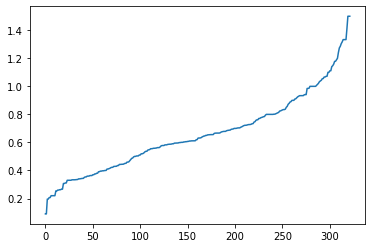

In [133]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2, metric='cityblock')
nbrs = neigh.fit(singapore_grouped_clustering)
distances, indices = nbrs.kneighbors(singapore_grouped_clustering)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [134]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=1.0, min_samples=2, metric='cityblock').fit(singapore_grouped_clustering)
clusterNum = len(set(db.labels_)) 
print('The number of clusters identified by DBSCAN is', clusterNum)

The number of clusters identified by DBSCAN is 6


In [135]:
# add clustering labels
subzone_venues_sorted_labledDB = subzone_venues_sorted
subzone_venues_sorted_labledDB.insert(0, 'Cluster Labels DB',db.labels_)

singapore_mergedDB = singapore_popDf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
singapore_mergedDB = singapore_mergedDB.join(subzone_venues_sorted_labledDB.set_index('SubZone_Name'), on='SubZone_Name')
singapore_mergedDB.dropna(axis=0, inplace=True)

In [136]:
cluster_counts = singapore_mergedDB.groupby('Cluster Labels DB').count()
cluster_counts['SubZone_Name']

Cluster Labels DB
-1.0     36
 0.0    278
 1.0      2
 2.0      2
 3.0      2
 4.0      2
Name: SubZone_Name, dtype: int64

In [198]:
singapore_clusters = singapore_mergedDB.groupby('Cluster Labels DB').mean().reset_index()
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'sing_1'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==0,'Cluster Labels DB'] = 'sing_2'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==1,'Cluster Labels DB'] = 'sing_3'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==2,'Cluster Labels DB'] = 'sing_4'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==3,'Cluster Labels DB'] = 'sing_5'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==4,'Cluster Labels DB'] = 'sing_6'
singapore_clusters

,Cluster Labels DB,Resident_Population,Age_(0-19),Age_(20-34),Age_(35-49),Age_(50-64),Age_(65-),HDB_1-2_rooms,HDB_3_rooms,HDB_4_rooms,HDB_5_rooms,Condos,Other_dwelling,Chinese,Malaya,Indian,Other_Ethnicity,SubZoneArea,latitude,longitude,x,y
0,sing_1,1693.055556,0.110012,0.104711,0.126952,0.106277,0.051026,0.026452,0.001031,0.007218,0.009675,0.008549,0.378971,0.391242,0.007994,0.043661,0.058095,6.705679,1.346311,103.812421,25674.311272,36493.910467
1,sing_2,13817.230216,0.155561,0.150500,0.188211,0.164864,0.104605,0.453727,0.030818,0.108143,0.178573,0.135460,0.278594,0.575322,0.068578,0.074774,0.044215,1.719589,1.343794,103.829175,27538.903640,36215.577600
2,sing_3,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.233293,1.355553,103.864880,31512.519182,37516.181624
3,sing_4,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.110108,1.321952,103.708741,14135.782952,33800.556522
4,sing_5,335.000000,0.107692,0.107692,0.084615,0.123077,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.492308,0.384615,0.007692,0.038462,0.069231,2.215169,1.353493,103.877381,32903.645688,37287.975134
5,sing_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.585053,1.214684,103.810952,25510.711961,21939.197109


In [216]:
ageDist = singapore_clusters.iloc[:,[0,2,3,4,5,6]]
ageDist.set_index('Cluster Labels DB', inplace=True, drop=True)

dwellingDist = singapore_clusters.iloc[:,[0,7,8,9,10,11,12]]
dwellingDist.set_index('Cluster Labels DB', inplace=True, drop=True)

ethnicityDist = singapore_clusters.iloc[:,[0,13,14,15,16]]
ethnicityDist.set_index('Cluster Labels DB', inplace=True, drop=True)

,Chinese,Malaya,Indian,Other_Ethnicity
Cluster Labels DB,,,,
sing_1,0.391242,0.007994,0.043661,0.058095
sing_2,0.575322,0.068578,0.074774,0.044215
sing_3,0.000000,0.000000,0.000000,0.000000
sing_4,0.000000,0.000000,0.000000,0.000000
sing_5,0.384615,0.007692,0.038462,0.069231
sing_6,0.000000,0.000000,0.000000,0.000000


In [217]:
def createPlots(df,cols,idxname,title):
    plotdf = df.iloc[:,cols]
    plotdf.set_index(idxname, inplace=True, drop=True)
    myPlot = plotdf.plot(kind='bar',  # create bar chart with size and color configuration
                       figsize = (20,8),
                       width = 0.8,
                       color = ('#172CE6', '#FFFF00', '#FF0000', '#00FF09', '#00F7FF', '#00F77F'),
                       fontsize = 14)
    myPlot.set_title(title, fontsize = 16) # set title for plot
    myPlot.legend(fontsize = 14, frameon = True, loc = 'upper right') # set legend, force location and border
    myPlot.spines['top'].set_visible(False)  # get rid of borders around the plot
    myPlot.spines['right'].set_visible(False)
    myPlot.spines['left'].set_visible(False)
    myPlot.yaxis.set_visible(False)  # get rid of y-axis
    # dislay percentages in proper formating on top of each bar
    for p in myPlot.patches:
        myPlot.annotate("{:.1%}".format(p.get_height()),
                    xy=(p.get_x()+0.02, p.get_height()+0.01))
    
    plt.show()

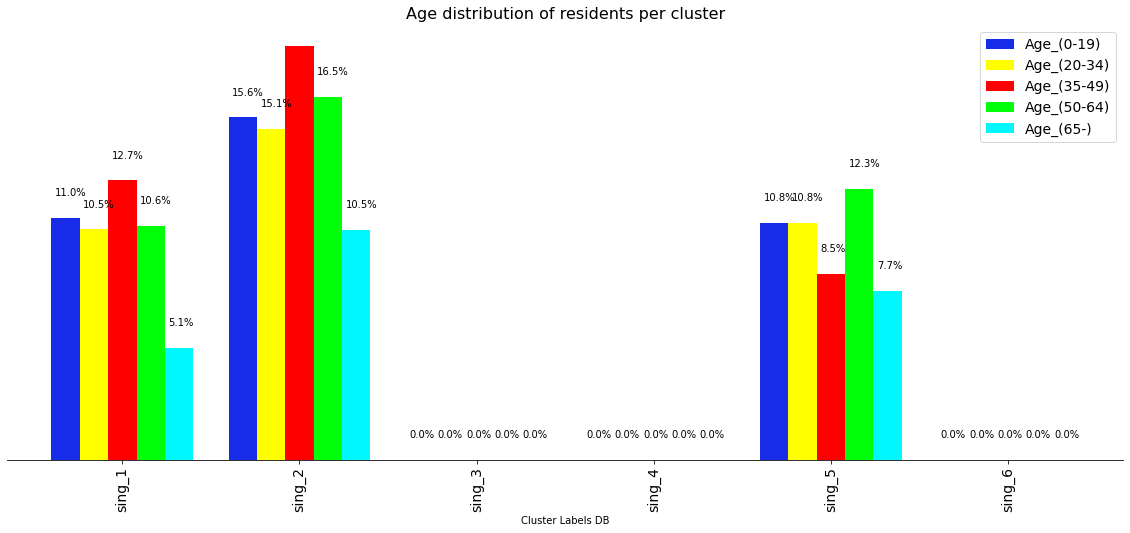

In [218]:
createPlots(singapore_clusters,[0,2,3,4,5,6],'Cluster Labels DB','Age distribution of residents per cluster')

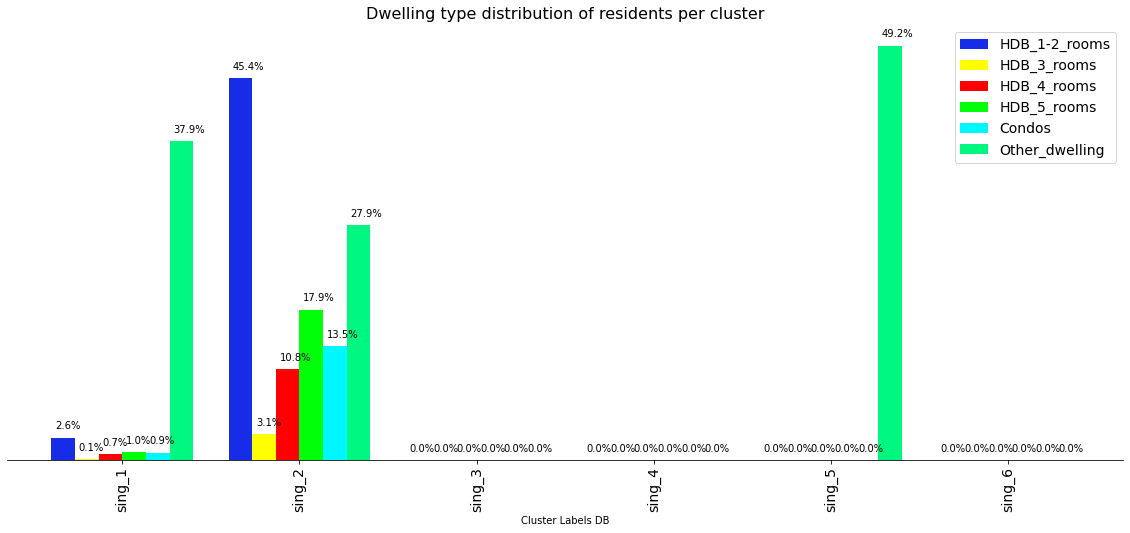

In [219]:
createPlots(singapore_clusters,[0,7,8,9,10,11,12],'Cluster Labels DB','Dwelling type distribution of residents per cluster')

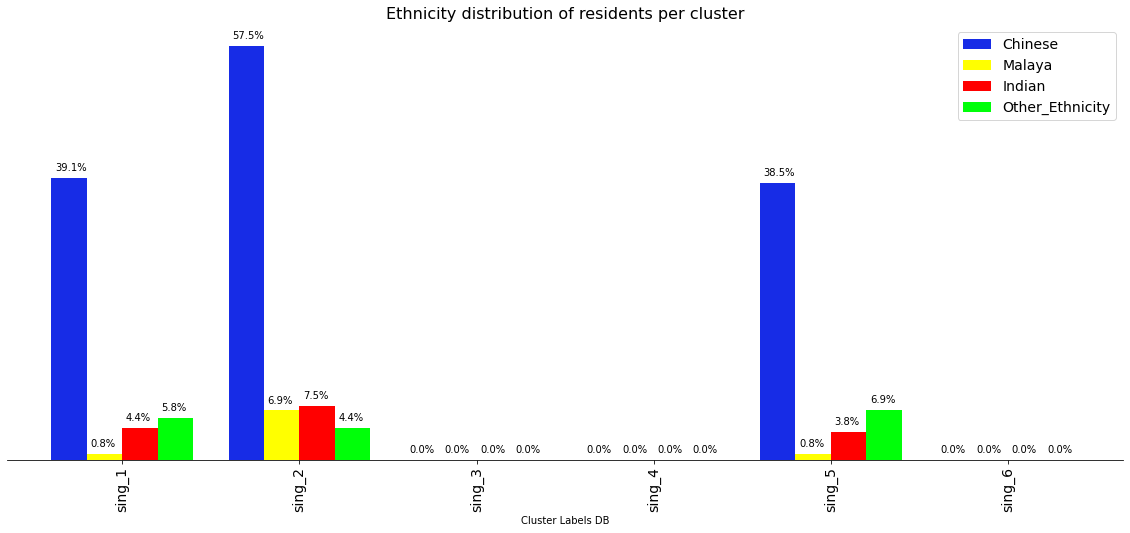

In [220]:
createPlots(singapore_clusters,[0,13,14,15,16],'Cluster Labels DB','Ethnicity distribution of residents per cluster')

In [138]:
# To render the folium map I use the default OpenStreetMaps tile
mySingapore_mapClust = folium.Map(location=singapore_coords, zoom_start=11, control_scale=True, tiles='OpenStreetMap') 

pointColor = {-1: '#172CE6', 0: '#FFFF00', 1: '#FF0000' , 2: '#00FF09', 3: '#00F7FF',4:'#00F77F'}


for lat, lng, subzone, region in zip(singapore_mergedDB['latitude'], singapore_mergedDB['longitude'], singapore_mergedDB['SubZone_Name'], singapore_mergedDB['Cluster Labels DB']):
    label = '{}, {}'.format(subzone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color =  pointColor[region],
        fill = True,
        fill_color = pointColor[region],
        fill_opacity = 0.7,
        parse_html = False).add_to(mySingapore_mapClust)


# Render interactive map including neighborhood locations:
mySingapore_mapClust

In [139]:
# add clustering labels
singapore_grouped_labled = singapore_grouped
singapore_grouped_labled.insert(0, 'Cluster Labels DB',db.labels_)

In [140]:
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'sing_1'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==0,'Cluster Labels DB'] = 'sing_2'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==1,'Cluster Labels DB'] = 'sing_3'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==2,'Cluster Labels DB'] = 'sing_4'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==3,'Cluster Labels DB'] = 'sing_5'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==4,'Cluster Labels DB'] = 'sing_6'

In [144]:
singapore_venues_clean_merged = singapore_venues_clean

singapore_venues_clean_merged = singapore_venues_clean_merged.join(singapore_grouped_labled.set_index('SubZone_Name'), on='SubZone_Name')
singapore_venues_clean_merged.dropna(axis=0, inplace=True)

In [146]:
singapore_grouped_label = getVenueFreq(singapore_venues_clean_merged,'Cluster Labels DB','Venue_Category', False)

In [147]:
singapore_onehot_label, singapore_label_grouped = getVenueFreq(singapore_venues_clean_merged,'Cluster Labels DB','Venue_Category', True)

In [148]:
singapore_label_sorted = getTopVenues(10, 'Cluster Labels DB', singapore_label_grouped)
singapore_label_sorted

,Cluster Labels DB,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,sing_1,Coffee Shop,Bar,Shop & Service,Public Transport,Trail,Chinese Restaurant,Park,Seafood Restaurant,Gym,Food Court
1,sing_2,Shop & Service,Coffee Shop,Chinese Restaurant,Food Court,Bar,Public Transport,Japanese Restaurant,Asian Restaurant,Tourist Accommodation,Gym
2,sing_3,Gym,Campground,Brewery,Trail,Recreation Center,Food Stand,General Entertainment,Garden,Fried Chicken Joint,French Restaurant
3,sing_4,Theme Park,Exhibit,Public Transport,Scenic Lookout,Coffee Shop,Park,Nightclub,Performing Arts Venue,Fishing Spot,Gym
4,sing_5,Shop & Service,Gym,Botanical Garden,Soup Place,Scandinavian Restaurant,Sandwich Place,Seafood Restaurant,Garden,Fried Chicken Joint,French Restaurant
5,sing_6,Other Great Outdoors,Island,Public Transport,Tourist Information Center,Pier,Beach,Food General,Garden,Fried Chicken Joint,French Restaurant


#### Neighborhoods in New York City

Next, I repeat the previous clusteirng excercise for neighborhoods in New York City.

In [6]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [7]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [10]:
np.unique(neighborhoods['Borough'])

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [11]:
nyc_coords = GetCityCoords('New York City, NY', 'Singapore_App')
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_coords[0],nyc_coords[1]))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=nyc_coords, zoom_start=10, control_scale=True)

pointColor = {'Bronx': '#172CE6', 'Brooklyn': '#FFFF00', 'Manhattan': '#FF0000' , 'Queens': '#00FF09', 'Staten Island': '#00F7FF'}

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=pointColor[borough],
        fill=True,
        fill_color=pointColor[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [14]:
venues_list = []
myLimit = 100 # this is the max allowed by the Foursquare API


# loop through all post code areas in the dataset and get Foursquare data for each post code area
for neighbor, boro, lat, lng in zip(neighborhoods['Neighborhood'], neighborhoods['Borough'], neighborhoods['Latitude'], neighborhoods['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    fSqure_credentials['CLIENT_ID'],
    fSqure_credentials['CLIENT_SECRET'],
    fSqure_credentials['VERSION'],
    lat,
    lng,
    600,
    myLimit)
    results = requests.get(url).json()
    loc_venue = results['response']['groups'][0]['items']
    venues_list.append([(neighbor,boro, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name'],v['venue']['categories'][0]['id']) for v in loc_venue])

nyc_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nyc_venues.columns = ['Neighborhood', 'Borough', 
                  'latitude', 
                  'longitude',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category',
                  'Venue_Category_ID']

nyc_venues.head()

,Neighborhood,Borough,latitude,longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Category_ID
0,Wakefield,Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4bf58dd8d48988d1d0941735
1,Wakefield,Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4bf58dd8d48988d10f951735
2,Wakefield,Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4bf58dd8d48988d1c9941735
3,Wakefield,Bronx,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,4bf58dd8d48988d10f951735
4,Wakefield,Bronx,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4bf58dd8d48988d148941735


In [15]:
nyc_venues_clean = nyc_venues
nyc_venues_clean = nyc_venues_clean[~nyc_venues_clean['Venue_Category_ID'].isin(dropList)]

In [17]:
for key in venue_lib:
    selection = nyc_venues_clean['Venue_Category_ID'].isin(venue_lib[key])
    nyc_venues_clean.loc[selection,'Venue_Category'] = key

In [54]:
nyc_onehot, nyc_grouped = getVenueFreq(nyc_venues_clean,'Neighborhood','Venue_Category', True)
nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Circus,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Cruise,Cuban Restaurant,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Exhibit,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Historic Site,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Mac & Cheese Joint,Malay Restaurant,Medical,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Museum,Music School,Music Venue,Nightclub,Nightlife Spot,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Rental Car Location,Rest Area,River,Rock Climbing Spot,Roller Rink,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Spiritual Center,Sports,Sri Lankan Restaurant,State / Provincial Park,Steakhouse,Street Art,Strip Club,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [83]:
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Circus,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Cruise,Cuban Restaurant,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Exhibit,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Historic Site,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Mac & Cheese Joint,Malay Restaurant,Medical,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Museum,Music School,Music Venue,Nightclub,Nightlife Spot,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Rental Car Location,Rest Area,River,Rock Climbing Spot,Roller Rink,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Spiritual Center,Sports,Sri Lankan Restaurant,State / Provincial Park,Steakhouse,Street Art,Strip Club,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.00,0.0,0.291667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

In [84]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

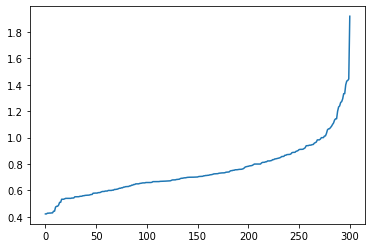

In [85]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, metric='cityblock')
nbrs = neigh.fit(nyc_grouped_clustering)
distances, indices = nbrs.kneighbors(nyc_grouped_clustering)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [86]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db_nyc = DBSCAN(eps=1.0, min_samples=2, metric='cityblock').fit(nyc_grouped_clustering)
clusterNum_nyc = len(set(db_nyc.labels_)) 
print('The number of clusters identified by DBSCAN is', clusterNum_nyc)

The number of clusters identified by DBSCAN is 5


In [87]:
# add clustering labels
nyc_grouped_labled = nyc_grouped
nyc_grouped_labled.insert(0, 'Cluster Labels DB',db_nyc.labels_)

In [90]:
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'nyc_1'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==0,'Cluster Labels DB'] = 'nyc_2'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==1,'Cluster Labels DB'] = 'nyc_3'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==2,'Cluster Labels DB'] = 'nyc_4'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==3,'Cluster Labels DB'] = 'nyc_5'

In [91]:
nyc_venues_clean_merged = nyc_venues_clean

nyc_venues_clean_merged = nyc_venues_clean_merged.join(nyc_grouped_labled.set_index('Neighborhood'), on='Neighborhood')
nyc_venues_clean_merged.dropna(axis=0, inplace=True)

In [100]:
nyc_onehot_label, nyc_label_grouped = getVenueFreq(nyc_venues_clean_merged,'Cluster Labels DB','Venue_Category', True)

,Cluster Labels DB,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Circus,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Cruise,Cuban Restaurant,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Exhibit,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Historic Site,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Mac & Cheese Joint,Malay Restaurant,Medical,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Museum,Music School,Music Venue,Nightclub,Nightlife Spot,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Rental Car Location,Rest Area,River,Rock Climbing Spot,Roller Rink,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Spiritual Center,Sports,Sri Lankan Restaurant,State / Provincial Park,Steakhouse,Street Art,Strip Club,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Yemeni Restaurant
0,nyc_1,0.000000,0.000000,0.013514,0.000000,0.003378,0.000000,0.000000,0.006757,0.033784,0.000000,0.000000,0.000000,0.010135,0.016892,0.050676,0.037162,0.000000,0.000000,0.000000,0.000000,0.003378,0.003378,0.000000,0.010135,0.003378,0.006757,0.000000,0.000000,0.000000,0.037162,0.000000,0.000000,0.016892,0.000000,0.027027,0.000000,0.003378,0.003378,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.043919,0.020270,0.003378,0.006757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020270,0.000000,0.000000,0.000000,0.006757,0.020270,0.000000,0.010135,0.000000,0.000000,0.000000,0.000000,0.003378,0.000000,0.000000,0.000000,0.006757,0.000000,0.043919,0.003378,0.003378,0.000000,0.000000,0.000000,0.000000,0.003378,0.00000,0.003378,0.003378,0.000000,0.000000,0.006757,0.000000,0.000000,0.010135,0.000000,0.000000,0.003378,0.023649,0.000000,0.000000,0.000000,0.003378,0.023649,0.000000,0.000000,0.027027,0.003378,0.000000,0.000000,0.000000,0.000000,0.0033

In [96]:
nyc_label_sorted = getTopVenues(10, 'Cluster Labels DB', nyc_label_grouped)
nyc_label_sorted

,Cluster Labels DB,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,nyc_1,Shop & Service,Bar,Gym,Deli / Bodega,Caribbean Restaurant,Tourist Accommodation,Beach,Park,Thai Restaurant,Athletics & Sports
1,nyc_2,Shop & Service,Bar,Coffee Shop,Gym,Pizza Place,Dessert Shop,Italian Restaurant,Deli / Bodega,Chinese Restaurant,Bakery
2,nyc_3,Beach,Gym,Bar,Bakery,Dessert Shop,Deli / Bodega,Chinese Restaurant,Mexican Restaurant,Shop & Service,Diner
3,nyc_4,Athletics & Sports,Dessert Shop,Gym,Playground,Harbor / Marina,Mexican Restaurant,Chinese Restaurant,Bike Rental / Bike Share,Pizza Place,Professional & Other Places
4,nyc_5,Park,Shop & Service,Public Transport,South American Restaurant,Medical,Pool,River,Dog Run,Sports,Thai Restaurant


#### Cross-city clusters

In [149]:
nyc_label_grouped.shape

(5, 193)

In [150]:
singapore_label_grouped.shape

(6, 153)

In [180]:
singapore_df = singapore_label_grouped.fillna(value='None')
nyc_df = nyc_label_grouped.fillna(value='None')

two_cities = pd.concat([singapore_df, nyc_df],sort=False).groupby('Cluster Labels DB').last().fillna(value=0.00)

In [181]:
two_cities.shape

(11, 204)

In [182]:
two_cities

,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bay,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Cruise,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Exhibit,Factory,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gun Range,Gym,Halal Restaurant,Harbor / Marina,Historic Site,Hot Dog Joint,Hot Spring,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Malay Restaurant,Medical,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mountain,Movie Theater,Museum,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Transport,Racetrack,Recreation Center,Reservoir,Rest Area,River,Rock Climbing Spot,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Ski Chalet,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Spiritual Center,Sports,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Afghan Restaurant,African Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caucasian Restaurant,Child Care Service,Circus,Colombian Restaurant,Comedy Club,Cuban Restaurant,Czech Restaurant,Daycare,Duty-free Shop,Egyptian Restaurant,Falafel Restaurant,Fountain,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Israeli Restaurant,Jewish Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Memorial Site,Mini Golf,Molecular Gastronomy Restaurant,Moroccan Restaurant,Music School,Nightlife Spot,Outdoors & Recreation,Pakistani Restaurant,Poke Place,Polish Restaurant,Public Art,Rental Car Location,Roller Rink,Romanian Restaurant,Russian Restaurant,Salvadoran Restaurant,Social Club,South American Restaurant,Souvlaki Shop,Sri Lankan Restaurant,State / Provincial Park,Street Art,Strip Club,Tibetan Restaurant,Turkish Restaurant,Varenyky restaurant,Yemeni Restaurant
Cluster Labels DB,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nyc_1,0.013514,0.000000,0.003378,0.000000,0.000000,0.006757,0.033784,0.000000,0.000000,0.010135,0.016892,0.050676,0.000000,0.037162,0.000000,0.000000,0.000000,0.000000,0.003378,0.000000,0.010135,0.003378,0.006757,0.000000,0.000000,0.037162,0.000000,0.016892,0.027027,0.000000,0.000000,0.000000,0.000000,0.043919,0.020270,0.003378,0.006757,0.000000,0.000000,0.000000,0.000000,0.000000,0.020270,0.000000,0.000000,0.000000,0.006757,0.020270,0.000000,0.010135,0.000000,0.000000,0.000000,0.003378,0.000000,0.000000,0.000000,0.006757,0.000000,0.000000,0.043919,0.003378,0.003378,0.000000,0.003378,0.000000,0.000000,0.003378,0.003378,0.000000,0.000000

values passed to leaf_label_func
leaves :  [9, 7, 2, 3, 10, 4, 8, 1, 6, 0, 5]


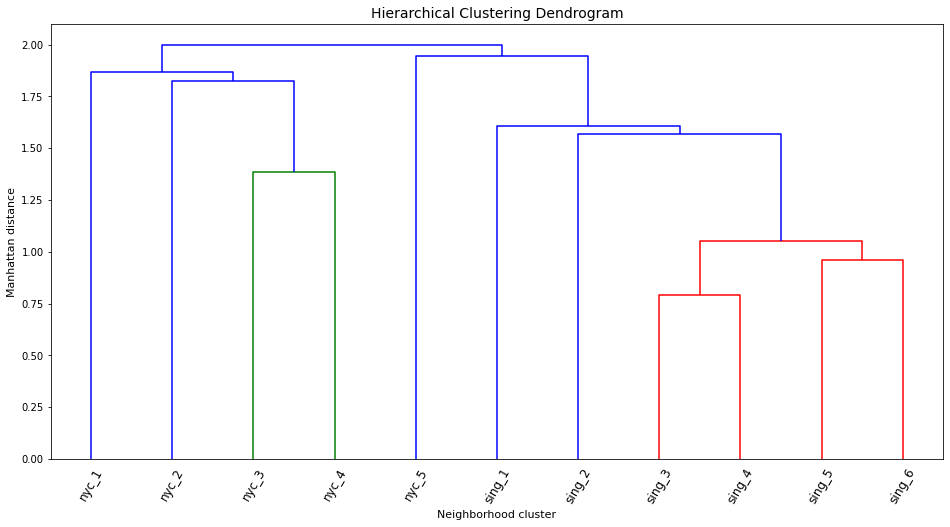

In [183]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(two_cities, metric='cityblock',method='complete')

labels = list(two_cities.index)
p = len(labels)

plt.figure(figsize=(16,8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Neighborhood cluster', fontsize=11)
plt.ylabel('Manhattan distance', fontsize=11)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])
# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()